# Inflation, unemploymet and gender in various work fields

The goal of this project is to analyze the employment rates of men and women across various industries. We intend to present both the overall employment figures and highlight differences within specific sectors. Our objective is to identify sectors where one gender is predominant over the other and vice versa. Additionally, we aim to examine employment growth rates over time and assess how external factors, such as the 2020 pandemic, have impacted workforce dynamics. Through this analysis, we seek to gain insights into gender representation in the labor market and understand the effects of external events on employment trends.

Imports and load of relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2
import plotly.graph_objects as go
import datetime
import pandas_datareader # install with `pip install pandas-datareader`
from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject as dp

#If you dont have the content below, remove the hashtag and install them

# pip install pandas-datareader
# %pip install git+https://github.com/alemartinello/dstapi
# %pip install pandas-datareader

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

# Read and clean data

Through API, we import data on inflation and unemployment.

## Importing inflation data from Denmark Statistics

We consider the following dictionary definitions wrt. table PRIS111

In [2]:
columns_dict = {}
columns_dict['VAREGR'] = 'variable'
columns_dict['ENHED'] = 'unit'
columns_dict['TID'] = 'year'
columns_dict['INDHOLD'] = 'value'

var_dict = {} # var is for variable
var_dict['00 Consumer price index, total'] = 'Y'


unit_dict = {}
unit_dict['Index'] = 'Indexnumber'
unit_dict['Percentage change compared to previous month (per cent)'] = 'pct month'
unit_dict['Percentage change compared to same month the year before (per cent)'] = 'pct year'


In [3]:
# Importing inflation data via Api.  
PRIS111_api = DstApi('PRIS111') 
params = PRIS111_api._define_base_params(language='en')

PRIS111 = PRIS111_api.get_data(params)


In [4]:
# PRIS111

In [5]:
# Renaming columns of the DataFrame PRIS111. 
PRIS111.rename(columns=columns_dict,inplace=True)

# Looping over the var dictionary.
for key,value in var_dict.items():
    PRIS111.variable.replace(key,value,inplace=True)

# Looping over the unit dictionary.
for key,value in unit_dict.items():
    PRIS111.unit.replace(key,value,inplace=True)



In [6]:
# Only keep rows where the variable is in `[Y]`. Afterwards convert the `value` column to a float.

# Ensuring 'year' is a string before applying string methods
PRIS111['year'] = PRIS111['year'].astype(str)

# Filter based on 'variable' values
var_vals = var_dict.values()
I_var = PRIS111['variable'].isin(var_vals)
PRIS111 = PRIS111[I_var]

# Grouping variables
# PRIS111.groupby(['variable','unit']).describe()

## Exploring data set

In [7]:
# Ensuring 'year' is a string before applying string methods
PRIS111['year'] = PRIS111['year'].astype(str)

# Filter based on 'variable' values
var_vals = var_dict.values()
I_var = PRIS111['variable'].isin(var_vals)
PRIS111 = PRIS111[I_var]

# Remove rows where 'unit' is either "Indexnumber" or "pct month"
units_to_exclude = ['Indexnumber', 'pct month']
I_unit = ~PRIS111['unit'].isin(units_to_exclude)
PRIS111 = PRIS111[I_unit]

# Filter to keep only rows where 'year' ends with "M12", then remove the "M12" part
I_year_suffix = PRIS111['year'].str.endswith("M12")
PRIS111 = PRIS111[I_year_suffix]
PRIS111['year'] = PRIS111['year'].str.replace('M12', '')

# Convert 'year' back to integer for proper comparison and sorting
PRIS111['year'] = PRIS111['year'].astype(int)

# Exclude rows before "2007" and the year "2023"
PRIS111 = PRIS111[(PRIS111['year'] >= 2007) & (PRIS111['year'] != 2023)]

# Sort the DataFrame by 'year' in ascending order
PRIS111 = PRIS111.sort_values(by='year')

# PRIS111



## Merge inflation- and unemployment data from Denmark Statistics

We merge with AULP01: Unemployment

In [8]:
FT_api = DstApi('AULP01')
params = FT_api._define_base_params(language='en')
params['variables'][0]['values'] = ['000']
params['variables'][1]['values'] = ['TOT']
params['variables'][2]['values'] = ['TOT']
params['variables'][3]['values'] = ['2007','2008','2009','2010','2011','2012','2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
## 000 is the code for all of Denmark, this can be seen by using: FT_api.variable_levels('HOVEDDELE', language='en')
unemp = FT_api.get_data(params=params)

unemp.rename(columns={'TID':'year','INDHOLD':'unemployment'},inplace=True)
unemp =  unemp.loc[:,['year','unemployment']]


In [9]:
# hint, merged = pd.merge(?,?,how='?',on=[?])
# merged_true.tail(10)

# Merge the DataFrames
merged = pd.merge(PRIS111, unemp, how='left', on=['year'])

# Display the tail of the new DataFrame
# merged.tail(20)

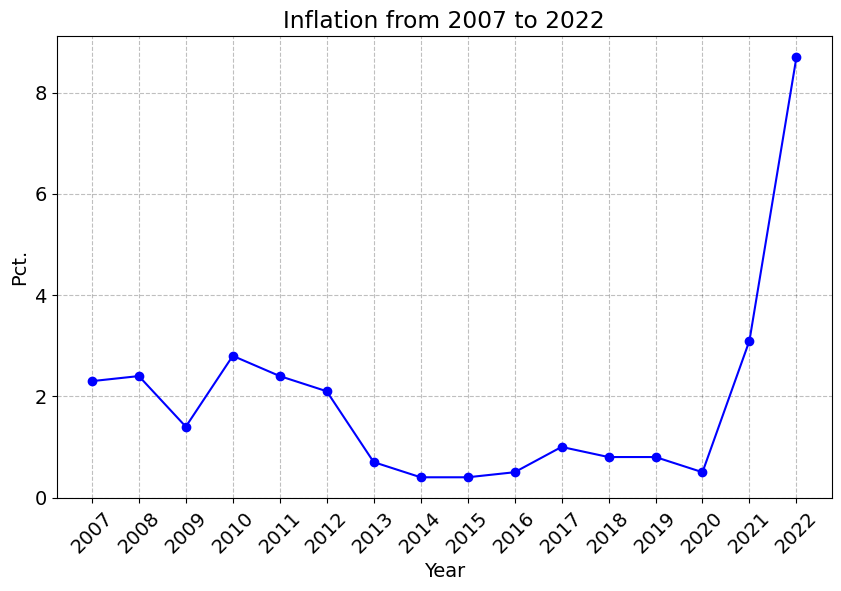

In [25]:
# Generating 
x_values = list(range(2007, 2023))  # From 2007 to 2022
y_values = [2.3, 2.4,1.4, 2.8, 2.4, 2.1, 0.7, 0.4, 0.4, 0.5, 1.0, 0.8, 0.8, 0.5, 3.1, 8.7]

# Plotting with the updated data
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
plt.title('Inflation from 2007 to 2022')
plt.xlabel('Year')
plt.ylabel('Pct.')
plt.xticks(x_values, rotation=45)  # Ensure all x-ticks (years) are shown and rotated for better readability
plt.grid(True)
plt.show()


We observe inflation in Denmark in the period 2007-22. Initially, it remained moderate, hovering between 2.3% and 2.8% from 2007 to 2011. This period saw generally stable economic conditions. A significant drop occurred between 2012 and 2015, with inflation rates plummeting to lows of 0.4% and 0.7%, indicative of a sluggish economic environment possibly influenced by global financial challenges. From 2016 to 2019, inflation was consistently mild, ranging between 0.5% and 1.0%, suggesting stable but slow economic growth. However, a sharp increase is observed in 2021 and 2022, with rates jumping to 3.1% and 8.7%. The relatively large increase in inflation to 8.7 pct. was mostly due to changes in prices in residential use, electricity, and heating. 

NB: we restrict ourselves to 2022, since there's not yet data for unemployment in 2023. In December 2013, inflation drops to 0.7 pct., which was largely due to decreasing energy prices. 

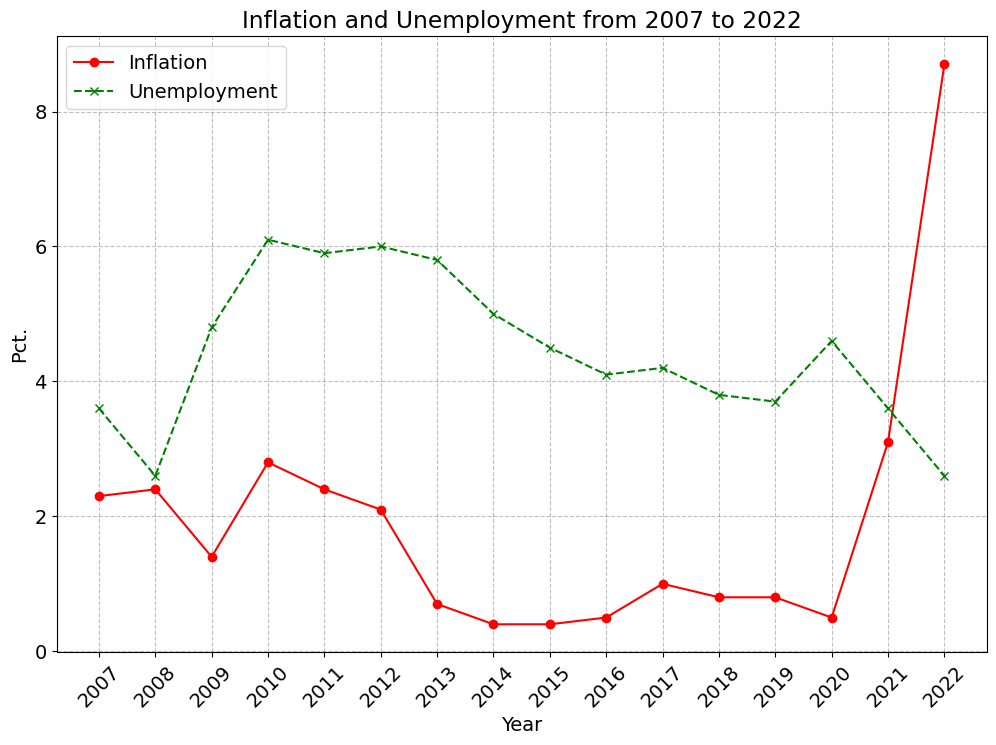

In [26]:
# Data for Plot 1 (Inflation from 2007 to 2022)
x_values_1 = list(range(2007, 2023))
y_values_1 = [2.3, 2.4, 1.4, 2.8, 2.4, 2.1, 0.7, 0.4, 0.4, 0.5, 1.0, 0.8, 0.8, 0.5, 3.1, 8.7]

# Data for Plot 2 (Unemployment)
x_values_2 = list(range(2007, 2023))
y_values_2 = [3.6, 2.6, 4.8, 6.1, 5.9, 6.0, 5.8, 5.0, 4.5, 4.1, 4.2, 3.8, 3.7, 4.6, 3.6, 2.6]

# Plotting both sets of data on the same graph
plt.figure(figsize=(12, 8))

# Plot 1: Inflation
plt.plot(x_values_1, y_values_1, marker='o', linestyle='-', color='r', label='Inflation')

# Plot 2: Unemployment
plt.plot(x_values_2, y_values_2, marker='x', linestyle='--', color='g', label='Unemployment')

# Customizing the plot
plt.title('Inflation and Unemployment from 2007 to 2022')
plt.xlabel('Year')
plt.ylabel('Pct.')
plt.xticks(x_values_1, rotation=45)  # Ensure all x-ticks (years) are shown and rotated for readability
plt.grid(True)
plt.legend()  # Show legend to differentiate between the two plots
plt.show()


In Denmark from 2007 to 2022, inflation and unemployment trends mirrored broader economic conditions. Initially, moderate inflation between 2.3% and 2.8% from 2007 to 2011 coincided with stable unemployment rates, peaking slightly in 2010 at 6.1%, reflecting the global economic downturn. As inflation rates plummeted to as low as 0.4% and 0.7% between 2012 and 2015, a sluggish economic environment persisted, marked by unemployment rates stabilizing around 6%. From 2016 to 2019, both inflation and unemployment displayed steady trends; mild inflation between 0.5% and 1.0% paired with a declining unemployment rate, stabilizing around 4%, suggested a period of economic recovery. The sharp inflation increase in 2021 and 2022 to 3.1% and 8.7%, primarily driven by spikes in residential use costs, electricity, and heating, occurred alongside a substantial drop in unemployment to a record low of 2.6%, indicating a complex interplay of rapid price increases and tightening labor markets. Thus it may seem, that inflation and unemployment has an inverse relationship.

To further understand unemployment we will analyze gender parity in different work fields.

## Employment rate in fields

In [12]:
#We import the employment tabel 'KAS301' from Denmarks Statistics
kas = DstApi('KAS301')

In [13]:
# Use the _define_base_params method to get a template and selects all available data. 
params = kas._define_base_params(language='en')
params

{'table': 'kas301',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'OMRÅDE', 'values': ['*']},
  {'code': 'BRANCHE07', 'values': ['*']},
  {'code': 'SOCIO', 'values': ['*']},
  {'code': 'ALDER', 'values': ['*']},
  {'code': 'KOEN', 'values': ['*']},
  {'code': 'PERIODE', 'values': ['*']},
  {'code': 'Tid', 'values': ['*']}]}

In [14]:
# We define what we want the dataset to contain
params= {'table': 'kas301',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'OMRÅDE', 'values': ['000']},
  {'code': 'BRANCHE07', 'values': ['A', 'H', 'L', 'K', 'CF']},
  {'code': 'SOCIO', 'values': ['02']},
  {'code': 'ALDER', 'values': ['*']},
  {'code': 'KOEN', 'values': ['TOT', 'K', 'M']},
  {'code': 'PERIODE', 'values': ['1']},
  {'code': 'Tid', 'values': ['>2011']}]}

In [15]:
# We load the data from dst via the api using the options specified in the param dictionary
kas_new=kas.get_data(params=params)
kas_new.head(100)

,OMRÅDE,BRANCHE07,SOCIO,ALDER,KOEN,PERIODE,TID,INDHOLD
0,All Denmark,"A Agriculture, forestry and fishing",Employed total,Under 16 years,Women,Whole year,2012,443
1,All Denmark,"A Agriculture, forestry and fishing",Employed total,Under 16 years,Men,Whole year,2012,1274
2,All Denmark,"A Agriculture, forestry and fishing",Employed total,Under 16 years,Total,Whole year,2012,1717
3,All Denmark,"A Agriculture, forestry and fishing",Employed total,16-19 years,Women,Whole year,2012,1030
4,All Denmark,"A Agriculture, forestry and fishing",Employed total,16-19 years,Men,Whole year,2012,3188
...,...,...,...,...,...,...,...,...
95,All Denmark,H Transportation,Employed total,25-29 years,Total,Whole year,2012,9343
96,All Denmark,H Transportation,Employed total,30-34 years,Women,Whole year,2012,2679
97,All Denmark,H Transportation,Employed total,30-34 years,Men,Whole year,2012,8463
98,All Denmark,H Transportation,Employed total,30-34 years,Total,Whole year,2012,11143


In [51]:
#We rename "OMRÅDE", "TID" and "INDHOLD"
kas_new.rename(columns={"OMRÅDE": "Place","TID": "Year","INDHOLD": "Employment", "ALDER": "Age", "KOEN": "Gender", "BRANCHE07": "Business",},  inplace =True)

# Here we are renaming the Business category to the following: Agriculture, Transportation, Pharmaceuticals, Real estate activities and Financial and Insurance.  
kas_new.loc[kas_new['Business'].str.contains('Agriculture'), 'Business'] = 'Agriculture'
kas_new.loc[kas_new['Business'].str.contains('Transportation'), 'Business'] = 'Transportation'
kas_new.loc[kas_new['Business'].str.contains('Pharmaceuticals'), 'Business'] = 'Pharmaceuticals'
kas_new.loc[kas_new['Business'].str.contains('Real estate activities'), 'Business'] = 'Real estate activities'
kas_new.loc[kas_new['Business'].str.contains('Financial and insurance'), 'Business'] = 'Financial and insurance'
#print(kas_new)

Printing descriptive statistics on gender and employment. 

In [17]:
kas_new.groupby(['Gender','Employment']).describe()

Year                                                  \
                  count         mean       std     min      25%     50%   
Gender Employment                                                         
Men    0            1.0  2021.000000       NaN  2021.0  2021.00  2021.0   
       1            6.0  2016.666667  3.076795  2012.0  2014.75  2017.5   
       2            3.0  2014.666667  1.527525  2013.0  2014.00  2015.0   
       17           1.0  2014.000000       NaN  2014.0  2014.00  2014.0   
       21           1.0  2013.000000       NaN  2013.0  2013.00  2013.0   
...                 ...          ...       ...     ...      ...     ...   
Women  37812        1.0  2021.000000       NaN  2021.0  2021.00  2021.0   
       37847        1.0  2014.000000       NaN  2014.0  2014.00  2014.0   
       38505        1.0  2022.000000       NaN  2022.0  2022.00  2022.0   
       38646        1.0  2013.000000       NaN  2013.0  2013.00  2013.0   
       39570        1.0  2012.000000       NaN  2012.0  2012.00  2012.0   

                                    
                       75%     max  
Gender Employment                   
Men    0           2021.00  2021.0  
       1           2018.75  2020.0  
       2           2015.50  2016.0  
       17          2014.00  2014.0  
       21          2013.00  2013.0  
...                    ...     ...  
Women  37812       2021.00  2021.0  
       37847       2014.00  2014.0  
       38505       2022.00  2022.0  
       38646       2013.00  2013.0  
       39570       2012.00  2012.0  

[2168 rows x 8 columns]

## Explore the dataset

We will now explore the final dataset by plotting the employment rates for gender and for different fields

In [18]:
# Define a color scale mapping for Gender
gender_color_map = {'Men': 'blue', 'Women': 'red', 'Total': 'gray'}

# Group by 'Year', 'Gender', and 'Age', and sum up the 'Employment' values
yearly_employment = kas_new.groupby(['Year', 'Gender'])['Employment'].sum().reset_index()

# Create a string representation for the x-axis labels
x_labels = [f"{year}, {gender}" for year, gender in zip(yearly_employment['Year'], yearly_employment['Gender'])]

# Map Gender categories to colors using the color scale, with fallback for unexpected values
colors = [gender_color_map.get(gender, 'gray') for gender in yearly_employment['Gender']]

# Create a bar trace with additional features for Gender and Age
bar_trace = go.Bar(x=x_labels, 
                   y=yearly_employment['Employment'],
                   marker=dict(color=colors),  # Use the color scale
                   hoverinfo='x+y+text',  # Show Year, Gender, Employment on hover
                   )

# Create the layout
layout = go.Layout(
    title='Average number of employed in Denmark by Gender',
    xaxis=dict(title='Year and Gender'), 
    yaxis=dict(title='Average employed')
)

# Create the figure object
fig = go.Figure(data=[bar_trace], layout=layout)

# Show the plot
fig.show()

This bar chart traces the employment trends in Denmark from 2012 to 2022, segmented by gender. Each year, men's employment rates outpace those of women, a consistent gender gap across the timeline. While the total employment displays marginal fluctuations, it broadly suggests a stable labor market. No year shows dramatic changes or deviations from this pattern.

Yearly employment by gender, field and business

In [27]:
import matplotlib.pyplot as plt
from ipywidgets import widgets, Output
from IPython.display import display
import pandas as pd

# Assuming kas_new is your DataFrame with the required data
# Make sure kas_new contains 'Year', 'Employment', 'Gender', and 'Business' columns

# Group by 'Year', 'Gender', and 'Business', and sum up the 'Employment' values
yearly_employment = kas_new.groupby(['Year', 'Gender', 'Business'])['Employment'].sum().reset_index()

# Create an output widget to manage plot output
plot_output = Output()

# Define update_plot function
def update_plot(year_range, gender, business):
    with plot_output:
        plot_output.clear_output(wait=True)  # Clear the previous plot before drawing a new one
        # Filter data
        filtered_data = yearly_employment[(yearly_employment['Year'] >= year_range[0]) &
                                          (yearly_employment['Year'] <= year_range[1]) &
                                          (yearly_employment['Gender'] == gender) &
                                          (yearly_employment['Business'] == business)]
        if not filtered_data.empty:
            # Plot filtered data
            plt.figure(figsize=(10, 6))
            plt.plot(filtered_data['Year'], filtered_data['Employment'], marker='o', linestyle='-')
            plt.title(f'Yearly Employment by Gender and Business ({gender}, {business})')
            plt.xlabel('Year')
            plt.ylabel('Employment')
            plt.grid(True)
            plt.show()

# Create interactive widgets for filtering
year_slider = widgets.IntRangeSlider(value=(yearly_employment['Year'].min(), yearly_employment['Year'].max()),
                                     min=yearly_employment['Year'].min(),
                                     max=yearly_employment['Year'].max(),
                                     step=1,
                                     description='Year Range:',
                                     continuous_update=False)

gender_dropdown = widgets.Dropdown(options=yearly_employment['Gender'].unique(),
                                   value=yearly_employment['Gender'].iloc[0],
                                   description='Gender:')

business_dropdown = widgets.Dropdown(options=yearly_employment['Business'].unique(),
                                     value=yearly_employment['Business'].iloc[0],
                                     description='Business:')

# Define callback function
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        update_plot(year_slider.value, gender_dropdown.value, business_dropdown.value)

# Attach callback function to widgets
year_slider.observe(on_change, names='value')
gender_dropdown.observe(on_change, names='value')
business_dropdown.observe(on_change, names='value')

# Display widgets and plot_output
display(year_slider, gender_dropdown, business_dropdown, plot_output)

# Initially display the plot with default values
update_plot((year_slider.value[0], year_slider.value[1]), gender_dropdown.value, business_dropdown.value)

IntRangeSlider(value=(2012, 2022), continuous_update=False, description='Year Range:', max=2022, min=2012)

Dropdown(description='Gender:', options=('Men', 'Total', 'Women'), value='Men')

Dropdown(description='Business:', options=('Agriculture', 'Financial and insurance', 'Pharmaceuticals', 'Real …

Output()

The figure highlights employment trends across various sectors, reflecting differences when including both genders. In agriculture, there has been a steady decline in jobs, while financial services and insurance initially saw a drop in employment from 2012 to 2015, followed by a subsequent increase. Pharmaceuticals and real estate sectors have experienced consistent growth in employment.

Transportation shows more variability, with employment fluctuating until 2015, then increasing significantly until 2019. The sector suffered during the pandemic, with a sharp employment drop, but recovered by 2022.

Gender-specific analysis reveals variations too. Agriculture has seen an increase in female employment despite a decline in male employment. In contrast, the financial and insurance sectors noted a decrease in female jobs from 2012 to 2016, then a rise until 2022, while male employment consistently increased.

In pharmaceuticals, employment trends were similar for both genders, though more women were employed, with numbers around 26,000 for females versus 22,000 for males in 2016. Real estate also showed higher employment rates for men, mirroring the pattern seen in pharmaceuticals.


# Conclusion

This project retrieves data from Danmarks Statistik via an API. We utilize datasets like AULP01, PRIS111, and KAS301 to analyze employment and inflation statistics. First, we found the inflation rate from 2007 to 2022, where we have seen a great increase in the years 2021 and 2022. After that we compared the inflation rate with the unemployment rate. Seeing that both these variables had almost the same trend. A bar chart has also been made,, where the total unemployment rate was compared to the unemployment rate of men and women. Overall, it was seen that the unemployment for men was almost twice as much as for women. The last objective of our project was to create an interactive plot, that could show the employment of the genders across different specific fields. The conclusion was that in some fields, such as the pharmaceutical field, female employees had increased and the opposite

## Experiment Real GDP

In [49]:
# Importing data from CSV file 'Real GDP'
GDP = pd.read_csv('GDP.csv',delimiter=';')

In [48]:
GDP.head(10)

,Year,GrossDP
0,2000,1677.2
1,2001,1691
2,2002,1698.9
3,2003,1705.5
4,2004,1751
5,2005,1792
6,2006,1862.1
7,2007,1879
8,2008,1869.4
9,2009,1777.7
